# Setting Up a Python Virtual Environment with `venv`

## Step 1: Create the Virtual Environment

First, create a virtual environment named `simpleuav`:

```bash
python -m venv simpleuav
source simpleuav/bin/activate

pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu118
pip install swig
pip install gymnasium[box2d]
pip install pygame
pip install numpy
pip install matplotlib
pip install ipykernel
```

### **state Space**
$(x, y, p_x, p_y, angle, L, mass, intertia)$ : most simplified

### **observation**
(FOV array)

### **Action space**
(Propulsion (acc in facing angle))
```python
if self.continuous:
    pass
else:
    thrust = np.array([0, 0])
    if action == 0:
        thrust[0] = 1
    elif action == 1:
        thrust[0] = -1
    elif action == 2:
        thrust[1] = 1
    elif action == 3:
        thrust[1] = -1

self.uav_pos_history.append((self.uav.position.x, self.uav.position.y))
Front_direction = Box2D.b2Vec2(math.cos(self.uav.angle), math.sin(self.uav.angle))
Right_direction = Box2D.b2Vec2(math.cos(self.uav.angle + math.pi / 2), math.sin(self.uav.angle + math.pi / 2))
thrust_force = (Front_direction * thrust[0] + Right_direction * thrust[1]) * cfg.UAV_THRUST_POW
```

### **Rewards**
*   increase/decrease the closer/durther the agent is to the goal.
*   increase/decrease the larger/smaller the magnitute of velocity $||v||$.
*   increase/decrease the larger/smaller the $\%$ of obstacle in FOV.

The episode receive an additional reward of -100 for crashing.

An episode is considered a solution if it reaches score.

### **Starting State**
The agent starts at the left ceter of the viewpoirt, with a initial $v_x$

### **Episode Termination**
If:
* The agent crashes
* The agent gets outside of the viewport
* Timeout (i.e., agent does not reach the goal after a certain number of steps)

**Note:** The obstacle generation is inefficient if too many obstacles are generated, and there is no guarantee each episode will have the exact number of obstacles. For more efficeint generation, please consider sample from a suitable distribution (say, Poisson distribution).

raw_reward:  [-3.56629652e-02  0.00000000e+00  9.43496470e-01 -2.98560270e+01
 -2.00000000e-03] 
reward:  -130.01747193484525
[ 0.50437495  0.53033092  0.62344146  0.85809422  1.63219134 10.
  5.18412524 10.         10.         10.          3.57847786  2.97161757
  3.10699719 10.         10.         10.          1.63219134  0.85809345
  0.62344202  0.53033151]
state:  [ 0.          0.          0.         -0.03566297 -0.17751107  0.9495625
  0.94696691  0.93765585  0.91419058  0.83678087  0.          0.48158748
  0.          0.          0.          0.64215221  0.70283824  0.68930028
  0.          0.          0.          0.83678087  0.91419066  0.9376558
  0.94696685]
0.0 28.442564759503856 -0.17751107407122246


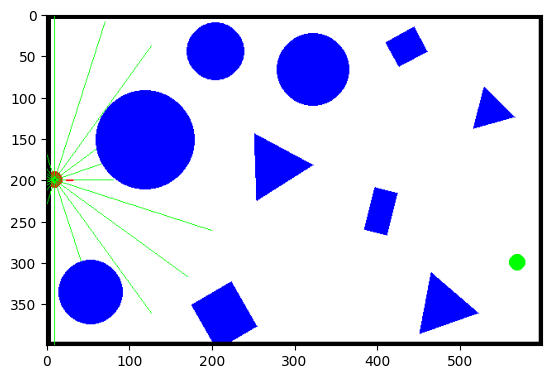

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle

from uav_sim import SimpleUAVEnv, DEFAULT_CONFIG
from dqn_agent import DQNAgent, train

env = SimpleUAVEnv(config=DEFAULT_CONFIG)
env.reset()
total_steps = 10  # Total number of steps in the test

# Run the test
for step in range(total_steps):
    action = 1 # go left
    state, reward, done, raw_reward = env.step(action)
    frame = env.render()
    if done:
        break
    # Pause for a short time to see the animation
    time.sleep(0.1)

env.close()
print('raw_reward: ', raw_reward, '\nreward: ', reward)
print(env._get_obs())
print('state: ', state)
print(env.uav.angle,env.dist2goal, env.ang2goal)
plt.imshow(frame)
#plt.savefig('test.png', dpi=600)

# Check reward

In [2]:
fov_reward = 0
print('OBS Offset: ', DEFAULT_CONFIG.OBS_OFFSET, 'UAV Radius: ', DEFAULT_CONFIG.UAV_RADIUS)
for distance in env._get_obs():
    print('distance: ', distance, ' PEN: ', env._leakyrelu_penalty(distance, offset=DEFAULT_CONFIG.OBS_OFFSET, max_penalty=DEFAULT_CONFIG.PEN_COLLISION)*DEFAULT_CONFIG.PEN_OBSTACLE)

OBS Offset:  1.5 UAV Radius:  0.5
distance:  0.5043749511241913  PEN:  -99.56250488758087
distance:  0.5303309249068913  PEN:  -96.96690750931087
distance:  0.6234414583225992  PEN:  -87.65585416774007
distance:  0.8580942201606324  PEN:  -64.19057798393676
distance:  1.6321913438833744  PEN:  0.0001321913438833744
distance:  10.0  PEN:  0.0085
distance:  5.184125239587321  PEN:  0.0036841252395873217
distance:  10.0  PEN:  0.0085
distance:  10.0  PEN:  0.0085
distance:  10.0  PEN:  0.0085
distance:  3.5784778594970703  PEN:  0.0020784778594970703
distance:  2.971617570849436  PEN:  0.001471617570849436
distance:  3.1069971885866736  PEN:  0.0016069971885866736
distance:  10.0  PEN:  0.0085
distance:  10.0  PEN:  0.0085
distance:  10.0  PEN:  0.0085
distance:  1.6321913438833744  PEN:  0.0001321913438833744
distance:  0.858093448621968  PEN:  -64.1906551378032
distance:  0.623442018878257  PEN:  -87.6557981121743
distance:  0.5303315143098257  PEN:  -96.96684856901743


Episode 100	Average Score: -132.28	Success rate: 0.00

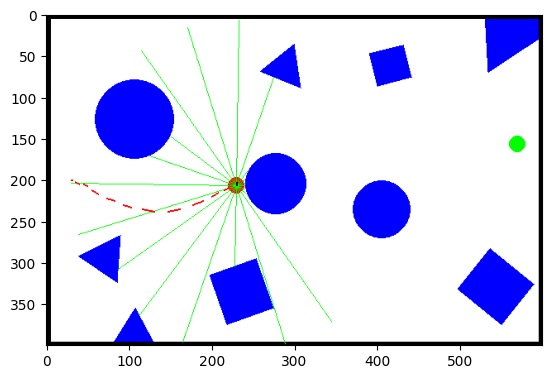

Episode 100	Average Score: -132.28, Eps: 0.606, Terminal vel: 3.766, angle:-0.02, dist2goal: 17.16, ang2goal: 0.16, step: 21, success rate: 0.00
Episode 128	Average Score: -111.63	Success rate: 0.03Goal reached! Vel:  6.366201400756836


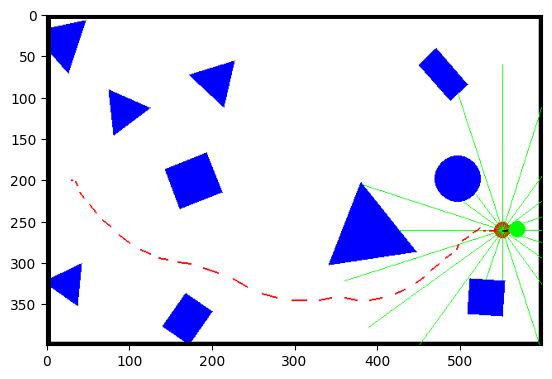

Episode 154	Average Score: -87.89	Success rate: 0.126Goal reached! Vel:  26.248510360717773


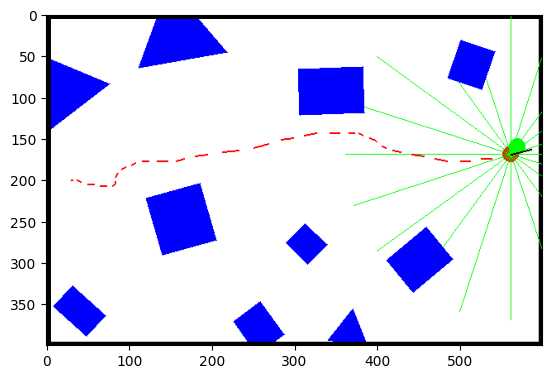

Episode 173	Average Score: -66.18	Success rate: 0.19Goal reached! Vel:  12.73239517211914


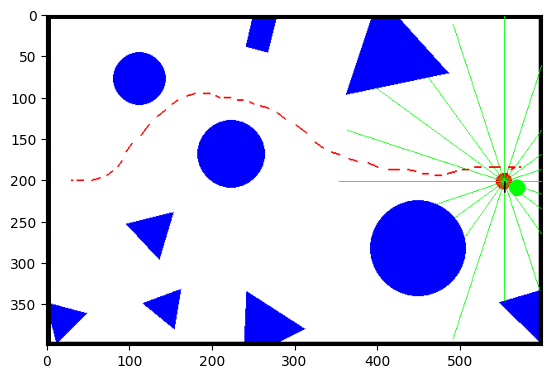

Episode 182	Average Score: -51.89	Success rate: 0.24Goal reached! Vel:  31.83098793029785


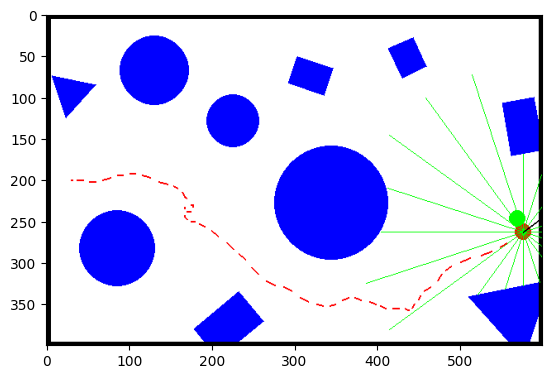

Episode 192	Average Score: -41.13	Success rate: 0.29Goal reached! Vel:  14.235250473022461


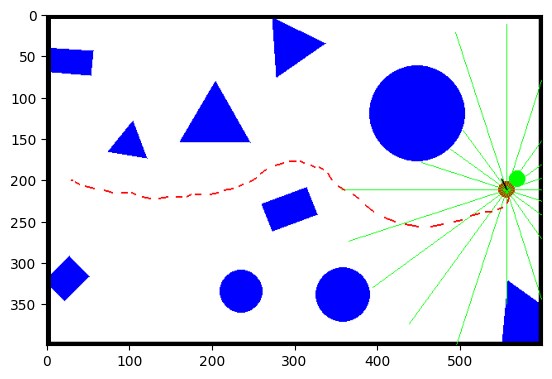

Episode 200	Average Score: -33.53	Success rate: 0.33

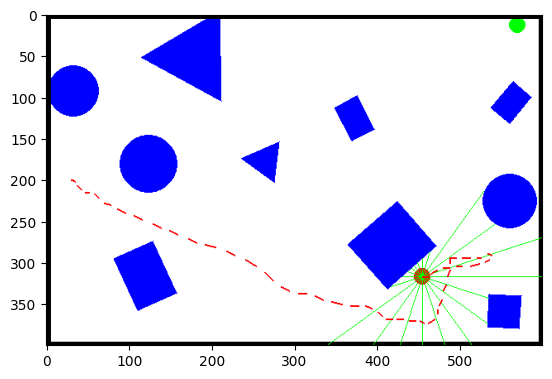

Episode 200	Average Score: -33.53, Eps: 0.367, Terminal vel: 6.366, angle:0.00, dist2goal: 16.25, ang2goal: 1.21, step: 99, success rate: 0.33
Episode 211	Average Score: -27.15	Success rate: 0.41Goal reached! Vel:  25.46479034423828


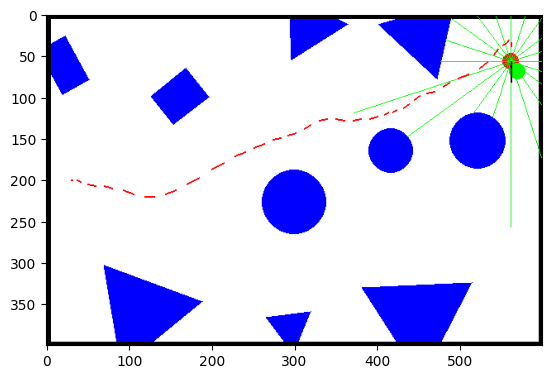

Episode 248	Average Score: -0.35	Success rate: 0.538Goal reached! Vel:  18.006322860717773


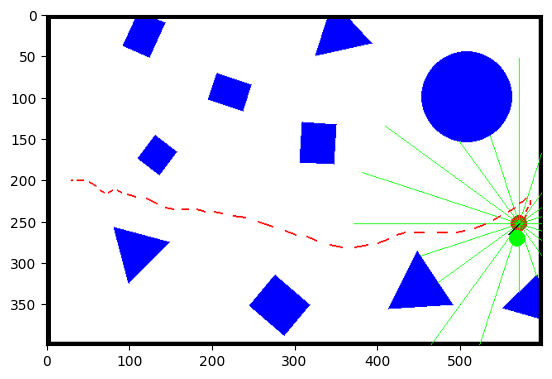

Episode 258	Average Score: 6.83	Success rate: 0.58Goal reached! Vel:  14.235250473022461


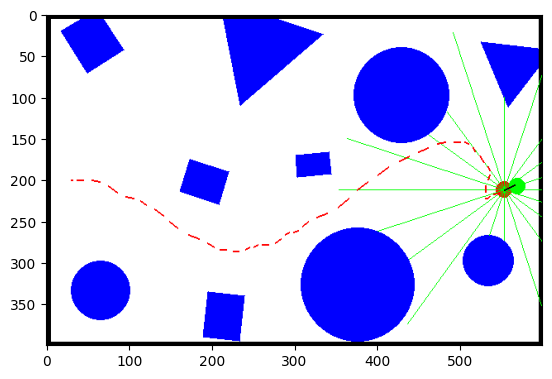

Episode 265	Average Score: 18.19	Success rate: 0.61Goal reached! Vel:  18.006328582763672


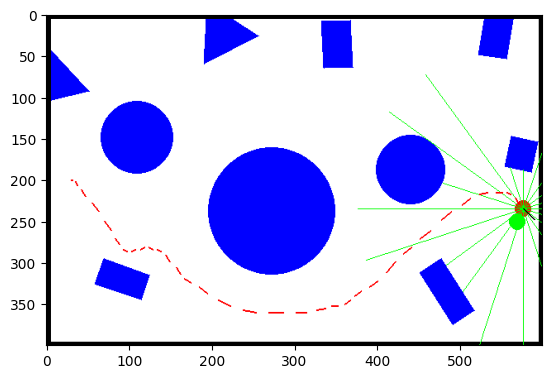

Episode 269	Average Score: 17.25	Success rate: 0.61Goal reached! Vel:  6.366201400756836


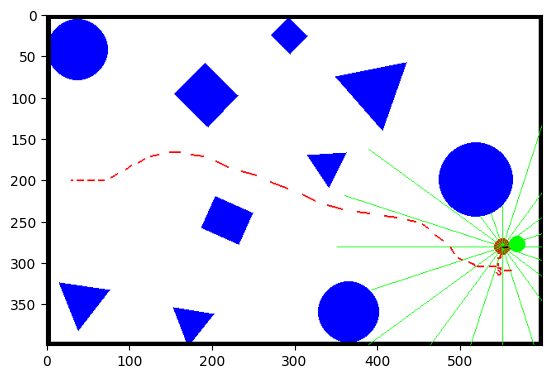

Episode 270	Average Score: 21.36	Success rate: 0.61Goal reached! Vel:  20.131683349609375


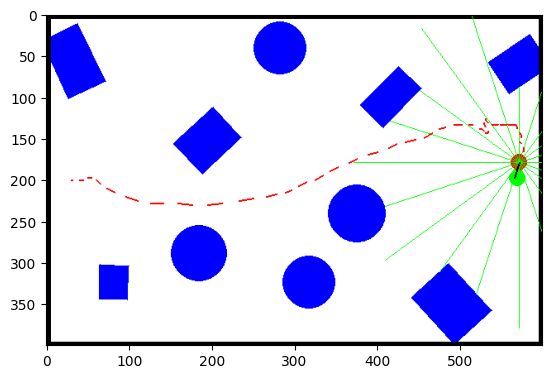

Episode 272	Average Score: 24.37	Success rate: 0.62Goal reached! Vel:  19.09859275817871


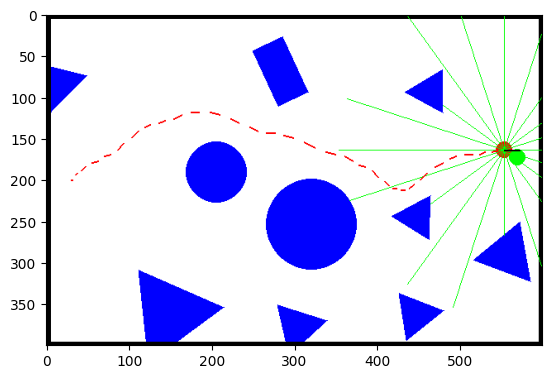

Episode 290	Average Score: 25.90	Success rate: 0.63Goal reached! Vel:  26.248510360717773


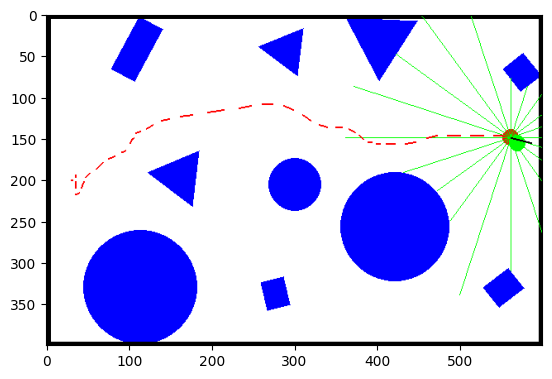

Episode 300	Average Score: 24.17	Success rate: 0.62

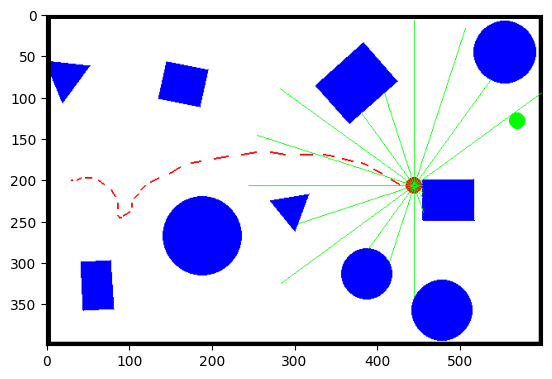

Episode 300	Average Score: 24.17, Eps: 0.222, Terminal vel: 0.140, angle:0.00, dist2goal: 7.33, ang2goal: 0.56, step: 48, success rate: 0.62


In [3]:
agent = DQNAgent(state_size=DEFAULT_CONFIG.STATE_SPACE, 
                 action_size=DEFAULT_CONFIG.ACTION_SPACE, 
                 type='conv',
                 uav_num_rays=DEFAULT_CONFIG.UAV_NUM_RAYS,
                 learning_rate=0.001,)

mean_scores, mean_steps = train(agent, env,
                                n_episodes=300,
                                n_max_step=100,
                                print_every=100,
                                )